# Synfire chain growth

The aim of this notebook is to investigate the formation of wide synfire chains via Ila Fiete's recipe of STDP + heterosynaptic competition + correlated input.

## Network Architecture
Conductance-based LIF network. Single-neuron voltage dynamics:

$$C_m \frac{dV}{dt} = g_l[E_l - V(t)] + g_e(t)[E_e - V(t)] + g_i(t)[E_i - V(t)] + I_{ext}(t)$$

The time-varying conductances $g_e(t)$ and $g_i(t)$ are exponentially filtered sums of spike trains from upstream neurons $j$, with time constants $\tau_e$ and $\tau_i$ and weighted by $W_e^{ij}$ and $W_i^{ij}$, respectively (convention: weight to $i$ from $j$):

$$\tau_e\frac{dg^i_e}{dt} = -g^i_e + \sum_j W_e^{ij} \sum_{t_k^j} \delta(t - t_k^j)$$

$$\tau_i\frac{dg^i_i}{dt} = -g^i_i + \sum_j W_i^{ij} \sum_{t_k^j} \delta(t - t_k^j)$$

where $t_k^j$ are the spike times in the $j$-th neuron.

# Code

In [33]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.linalg import block_diag
import pandas as pd
from tqdm import tqdm
import pickle
from collections import OrderedDict
import os
from scipy.ndimage.interpolation import shift
from functools import reduce

from aux import Generic
from disp import set_font_size, get_spaced_colors
from ntwk import LIFNtwkG
from utils.general import *

cc = np.concatenate

# PARAMS
## NEURON AND NETWORK MODEL
M = Generic(
    # Excitatory membrane
    C_M_E=1e-6,  # membrane capacitance
    G_L_E=.4e-3,  # membrane leak conductance (T_M (s) = C_M (F/cm^2) / G_L (S/cm^2))
    E_L_E=-.06,  # membrane leak potential (V)
    V_TH_E=-.05,  # membrane spike threshold (V)
    T_R_E=0.5e-3,  # refractory period (s)
    E_R_E=-0.055, # reset voltage (V)
    
    # Inhibitory membrane
    #C_M_I=1e-6,
    #G_L_E=.1e-3, 
    #E_L_I=-.06,
    #V_TH_E=-.05,
    #T_R_I=.002,
    
    # syn rev potentials and decay times
    E_E=0, E_I=-.07, T_E=.006, T_I=.004,
    
    W_U_E=0.5e-3,
    W_MAX=0.26 * 0.004,
    M=1.,
    ETA=0.00005,
    EPSILON=0.05,
    
    W_E_I_R=0,
    W_I_E_R=0,
    
    N_EXC=50,
    N_INH=1,
    
    DRIVING_HZ=5, # 10 Hz lambda Poisson input to system
    N_DRIVING_CELLS=10,
    PROJECTION_NUM=5,
    W_INITIAL=0.,
    
    # OTHER INPUTS
    SGM_N=.5e-9,  # noise level (A*sqrt(s))
    I_EXT_B=0,  # additional baseline current input
)

## SMLN
S = Generic(RNG_SEED=0, DT=0.1e-3)

print('T_M_E =', 1000*M.C_M_E/M.G_L_E, 'ms')  # E cell membrane time constant (C_m/g_m)

T_M_E = 2.5 ms


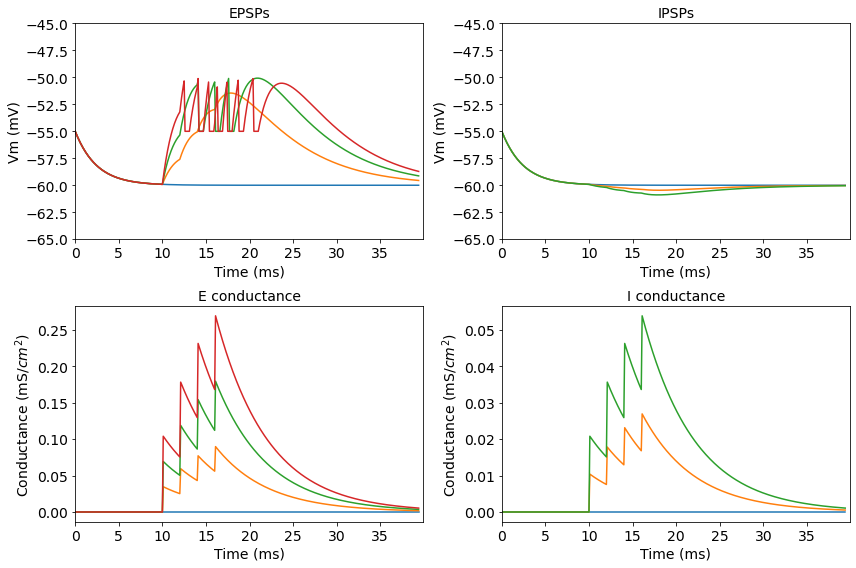

In [38]:
np.random.seed(0)
# EPSP size vs E weight
t = np.arange(0, .04, S.DT)
rsps_e = []

output_dir_name = f'single_cell_{time_stamp(s=True)}'

t_r_int = int(2e-3/S.DT)
burst_t = np.arange(0, 4 * t_r_int, t_r_int, dtype=int)

for w_u_e_e in np.arange(4)/3. * M.W_MAX * 0.1:
    w_u_e_i = 0

    ntwk = LIFNtwkG(
        c_m=M.C_M_E,
        g_l=M.G_L_E,
        e_l=M.E_L_E,
        v_th=M.V_TH_E,
        v_r=M.E_R_E,
        t_r=M.T_R_E,
        e_s={'E': M.E_E, 'I': M.E_I},
        t_s={'E': M.T_E, 'I': M.T_I},
        w_r={'E': np.zeros([1]*2), 'I': np.zeros([1]*2)},
        w_u={'E': np.array([w_u_e_e, 0]), 'I': np.array([0, w_u_e_i])},
        plasticity_indices=[],
        connectivity=np.ones([1]*2),
        W_max=0,
        m=1,
        eta=0,
        epsilon=0,
        gamma=0,
        alpha=0,
        fr_set_points=0,
        dt=S.DT,
        output=False)
    
    spks_u = np.zeros((len(t), 2), dtype=int)
    spks_u[int(round(.01/S.DT)) + burst_t, 0] = 1
    rsp = ntwk.run(
        dt=S.DT,
        clamp=Generic(v={0: np.array([M.E_R_E])}, spk={}),
        i_ext=np.zeros(len(t)),
        spks_u=spks_u,
        output_dir_name=output_dir_name
    )
    
    rsps_e.append(copy(rsp))

# IPSP size vs I weight
rsps_i = []

for w_u_e_i in np.arange(3) * M.W_MAX / M.M * 0.01:
    w_u_e_e = 0

    ntwk = LIFNtwkG(
        c_m=M.C_M_E,
        g_l=M.G_L_E,
        e_l=M.E_L_E,
        v_th=M.V_TH_E,
        v_r=M.E_R_E,
        t_r=M.T_R_E,
        e_s={'E': M.E_E, 'I': M.E_I},
        t_s={'E': M.T_E, 'I': M.T_E},
        w_r={'E': np.zeros([1]*2), 'I': np.zeros([1]*2)},
        w_u={'E': np.array([w_u_e_e, 0]), 'I': np.array([0, w_u_e_i])},
        plasticity_indices=[],
        connectivity=np.ones([1]*2),
        W_max=0,
        m=1,
        eta=0,
        epsilon=0,
        gamma=0,
        alpha=0,
        fr_set_points=0,
        dt=S.DT,
        output=False)
    
    spks_u = np.zeros((len(t), 2), dtype=int)
    spks_u[int(round(.01/S.DT)) + burst_t, 1] = 1
    rsp = ntwk.run(
        dt=S.DT,
        clamp=Generic(v={0: np.array([M.E_R_E])}, spk={}),
        i_ext=np.zeros(len(t)),
        spks_u=spks_u,
        output_dir_name=output_dir_name
    )
    
    rsps_i.append(copy(rsp))
    
# plot
fig, axs = plt.subplots(2, 2, figsize=(12, 8), tight_layout=True)
for rsp_e in rsps_e:
    axs[0, 0].plot(1000*t, 1000*rsp_e.vs[:, 0])
    axs[1, 0].plot(1000*t, 1000*rsp_e.gs['E'][:, 0])
for rsp_i in rsps_i:
    axs[0, 1].plot(1000*t, 1000*rsp_i.vs[:, 0])
    axs[1, 1].plot(1000*t, 1000*rsp_i.gs['I'][:, 0])
    
for ax in axs[0, :]:
    ax.set_xlim(1000*t.min(), 1000*t.max())
    ax.set_ylim(-65, -45)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Vm (mV)')
    
for ax in axs[1, :]:
    ax.set_xlim(1000*t.min(), 1000*t.max())
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Conductance (mS/$cm^2$)')
    
axs[0, 0].set_title('EPSPs')
axs[0, 1].set_title('IPSPs')

axs[1, 0].set_title('E conductance')
axs[1, 1].set_title('I conductance')
    
for ax in axs.flatten():
    set_font_size(ax, 14)

# Full chain